Hi, welcome to simple sequence to sequence model using dynamic RNN and LSTM for activation gate, based on this research paper [Sequence to Sequence Learning with Neural Networks, Ilya Sutskever, Oriol Vinyals, Quoc V. Le, 2014](https://arxiv.org/pdf/1409.3215)

Encoder part also a network of shallow/deep recurrent, and same goes to decoder network. Both necessary have same size.

![alt text](https://raw.githubusercontent.com/ematvey/tensorflow-seq2seq-tutorials/bbc28439151a95a79bc83f8bc4e30bdc1b0ea4d9/pictures/1-seq2seq.png)

![alt text](http://suriyadeepan.github.io/img/seq2seq/seq2seq2.png)

This model is very good in to become translator model, chatbot, and even text compression.

Our encoder side will learn input vectors and compressed the inputs into certain noise vector, called thought vector, and this vector will be used in decoder part to change that compressed noise into useful information.

Let say, i have a word 'i like husein', and i want to translate this word into bahasa, like this, 'saya suka husein'.

When I put 'i like husein' into encoder part, it will change into thought vectors, 'i' maybe become 1, 'like' maybe become 100, 'husein' maybe 1000. and our decoder part must learn, if it received 1, it must be 'i', if 100, it must be 'like' and so on so on. It will learn to match thought vector with the correct output.

This time i want to predict incoming word if i said 'hello, my name is husein'. and the model we trained later should know how to respond 'ok bro' or something like that, depends on dataset.

But we are using bahasa subtitle, from Assassination Classroom The Graduation (2016)! What should model predict if i put 'Markas Pusat. Ini Maruhito', the model should predict, 'Markas Pusat. Ini Maruhito' also. Simple as that.

Even lines are the prediction or target, odd lines are the inputs.

I need to clean the dataset first, change into integer representation. But before we changed into integer representation, we do minor biased for our model, the dataset will sorted from highest frequency to least frequency. 

In [1]:
with open('/home/huseinzol05/AI/chat/Assassination Classroom The Graduation (2016) BluRay 720p 900MB Ganool is.srt', 'r') as fopen:
    text = fopen.read().split('\n')
text = filter(None, text)

In [2]:
# any first character in a string is digit or '\r' or '<', we remove the string
# but we must start from the back, or later python will throw exception because the index no longer exist
for i in reversed(xrange(len(text))):
    if text[i][0].isdigit() or text[i][0] == '\r' or text[i][0] == '<':
        del text[i]

# replace all '\r' with empty character
text = [i.replace('\r', '') for i in text]
# strip spaces with empty character
text = [i.strip() for i in text]

import re
# remove non ascii from our string
text = [re.sub(r'[^\x00-\x7F]+','', i) for i in text]

text

['Markas Pusat. Ini Maruhito.',
 'Visual bagus.',
 'Markas Pusat. Ini Maruhito.',
 'Visual bagus.',
 'Maskas Pusat. Ini Maruhito.',
 'Kami tiba di lokasi.',
 'Markas Pusat. Ini Marufuta.',
 'Bersedia di lokasi penembak tepat.',
 'Ini Marumaru. Diterima. Bersedia dan tunggu arahan',
 'seterusnya sebelum menembak.',
 'Markas Pusat. Ini Maruhito.',
 'Kami akan buka pintu.',
 'Disini Marumaru.',
 'Diterima.',
 'Markas Pusat. Ini Maruhito.',
 'Sasaran bergerak.',
 'Peralatan keselamatan dan senapang sudah terisi.',
 'Markas pusat. Ini Marufuta.',
 'Ikuti gerakan sasaran ke arah pukul 2.',
 'Ini Marumaru. Difaham.',
 'Disini Maruhito.',
 'Setiap pasukan, awasi sasaran.',
 'Akulah...',
 'yang menghancurkan separuh bulan kamu.',
 'Aku merancang perkara sama pada Bumi',
 'bulan Mac tahun depan.',
 'Tapi hingga saat itu, aku akan jadi guru kelas kamu.',
 'Selamat berkenalan.',
 'Makhluk Super Misterius',
 'Kami, adalah murid buangan Sekolah Menengah Kunugigaoka,',
 'juga di kenal sebagai "E untu

Now we need vocabulary and dictionary for our input and predict.

step:

1- We split the dataset into input and predict. Even line is predict, else is input.

2- Then we tokenized each sentence in both dataset, turn into vocabulary.

['saya suka makan nasi goreng', 'makan mee udang']

[['saya', 'suka'.. n], ['makan', 'mee', 'udang']]

3- Then we sorted our tokenized words from highest freq to lowest freq.

4- Then we turned our sorted words into unique words, while maintaining the position of sorting.

5- Then turned into dictionary {'husein': 0, 'suka': 1.. n}

In [3]:
inputs = []; predict = []

# We split the dataset into input and predict. Even line is predict, else is input.
for i in xrange(len(text)):
    if i % 2 == 0:
        predict.append(text[i])
    else:
        inputs.append(text[i])
        
vocab_inputs = []; vocab_predict = []
# Then we tokenized each sentence in both dataset, turn into vocabulary.
for i in xrange(len(inputs)):
    vocab_inputs += inputs[i].split(); vocab_predict += predict[i].split()

# Then we sorted our tokenized words from highest freq to lowest freq.
vocab_inputs = sorted(vocab_inputs,key = vocab_inputs.count,reverse = True)
vocab_predict = sorted(vocab_predict,key = vocab_predict.count,reverse = True)

d1 = dict((k,v) for v,k in enumerate(reversed(vocab_inputs)))
d2 = dict((k,v) for v,k in enumerate(reversed(vocab_predict)))

# Then we turned our sorted words into unique words, while maintaining the position of sorting.
vocab_inputs = ['PAD', 'EOS'] + sorted(d1, key = d1.get, reverse = True)
vocab_predict = ['PAD', 'EOS'] + sorted(d2, key = d2.get, reverse = True)

print 'vocab size for inputs: ' + str(len(vocab_inputs))
print 'vocab size for predict: ' + str(len(vocab_predict))

# Then turned into dictionary {'husein': 0, 'suka': 1.. n}
dict_inputs = dict(zip(vocab_inputs, [i for i in xrange(len(vocab_inputs))]))
dict_predict = dict(zip(vocab_predict, [i for i in xrange(len(vocab_predict))]))

vocab size for inputs: 1496
vocab size for predict: 1533


In [4]:
split_inputs = []; split_predict = []
for i in xrange(len(inputs)):
    split_inputs.append(inputs[i].split()); split_predict.append(predict[i].split())

greatestvalue_inputs = 0; greatestvalue_predict = 0
for i in xrange(len(split_inputs)):
    if len(split_inputs[i]) > greatestvalue_inputs:
        greatestvalue_inputs = len(split_inputs[i])
        
for i in xrange(len(split_predict)):
    if len(split_predict[i]) > greatestvalue_predict:
        greatestvalue_predict = len(split_predict[i])

# need to add one because our decoder need to include EOS
greatestvalue_predict += 1

print 'longest sentence in our input dataset: ' + str(greatestvalue_inputs)
print 'longest sentence in out predict dataset: ' + str(greatestvalue_predict)

longest sentence in our input dataset: 12
longest sentence in out predict dataset: 16


Now we import our tensorflow and design our dynamic rnn

I'm still using Tensorflow 0.12 and will use most of the API from Tensorflow to make it short.

0.12, API for LSTM tf.nn.rnn_cell.LSTMCell

1.X, API for tf.contrib.rnn.LSTMCell

In [5]:
import numpy as np
import tensorflow as tf
import helpers
sess = tf.InteractiveSession()

encoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32)
decoder_targets = tf.placeholder(shape = (None, None), dtype = tf.int32)
decoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32)

In [6]:
encoder_embeddings = tf.Variable(tf.random_uniform([len(vocab_inputs), greatestvalue_predict]
                                                   , -1.0, 1.0), dtype = tf.float32)

decoder_embeddings = tf.Variable(tf.random_uniform([len(vocab_predict), greatestvalue_predict]
                                                   , -1.0, 1.0), dtype = tf.float32)


encoder_inputs_embedded = tf.nn.embedding_lookup(encoder_embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(decoder_embeddings, decoder_inputs)

# Encoder part

In [7]:
# RNN size of greatestvalue_inputs
encoder_cell = tf.nn.rnn_cell.LSTMCell(greatestvalue_predict)

# 2 layers of RNN
encoder_rnn_cells = tf.nn.rnn_cell.MultiRNNCell([encoder_cell] * 2)

_, encoder_final_state = tf.nn.dynamic_rnn(encoder_rnn_cells, encoder_inputs_embedded,
                                           dtype = tf.float32, time_major = True)

# Decoder part

In [8]:
# RNN size of greatestvalue_predict
decoder_cell = tf.nn.rnn_cell.LSTMCell(greatestvalue_predict)

# 2 layers of RNN
decoder_rnn_cells = tf.nn.rnn_cell.MultiRNNCell([decoder_cell] * 2)

# declare a scope for our decoder, later tensorflow will confuse
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(decoder_rnn_cells, decoder_inputs_embedded, 
                                                         initial_state = encoder_final_state,
                                           dtype = tf.float32, time_major = True, scope ='decoder')

In [9]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, len(vocab_predict))

decoder_prediction = tf.argmax(decoder_logits, 2)

In [10]:
# this might very costly if you have very large vocab
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels = tf.one_hot(decoder_targets, depth = len(vocab_predict), dtype = tf.float32),
    logits = decoder_logits)

loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

sess.run(tf.global_variables_initializer())

Now we create a function to generate integer input and predict for our model. Let we flashback our model based on the paper

![alt text](https://raw.githubusercontent.com/ematvey/tensorflow-seq2seq-tutorials/bbc28439151a95a79bc83f8bc4e30bdc1b0ea4d9/pictures/1-seq2seq.png)

if our encoder input is [5, 6, 7], decoder predicts must be [5, 6, 7, 1] right?

decoder input must [1, 5, 6, 7], decoder lagged 1 step, passing previous token as input at current step

In [11]:
batch_size = 50
epoch = 3000
LOSS = []

def feeding(inputs, labels):
    inputs_int = []; predict_int = []
    for i in xrange(len(inputs)):
        single_input = []
        single_predict = []
        for x in xrange(len(labels[i])):
            try:
                single_input += [dict_inputs[inputs[i][x]]]
            except:
                single_input += [0]
        for x in xrange(len(labels[i])):
            single_predict += [dict_predict[labels[i][x]]]
        inputs_int.append(single_input); predict_int.append(single_predict)
            
    enc_input, _ = helpers.batch(inputs_int)
    dec_target, _ = helpers.batch([(sequence) + [1] for sequence in predict_int])
    dec_input, _ = helpers.batch([[1] + (sequence) for sequence in inputs_int])
    
    return {encoder_inputs: enc_input, decoder_inputs: dec_input, decoder_targets: dec_target}

In [12]:
import time

for q in xrange(epoch):
    total_loss = 0
    lasttime = time.time()
    for w in xrange(0, len(split_inputs) - batch_size, batch_size):
        _, losses = sess.run([optimizer, loss], 
                             feeding(split_inputs[w: w + batch_size], split_predict[w: w + batch_size]))
        
        total_loss += losses
        
    total_loss = total_loss / ((len(split_inputs) - batch_size) / (batch_size * 1.0))
    LOSS.append(total_loss)
    
    if (q + 1) % 100 == 0:
        print 'epoch: ' + str(q + 1) + ', total loss: ' + str(total_loss) + ', s/epoch: ' + str(time.time() - lasttime)

epoch: 100, total loss: 2.81796976521, s/epoch: 0.893946886063
epoch: 200, total loss: 2.43092585254, s/epoch: 0.897614955902
epoch: 300, total loss: 2.090692794, s/epoch: 0.90088391304
epoch: 400, total loss: 1.81174978211, s/epoch: 0.929155111313
epoch: 500, total loss: 1.63233603175, s/epoch: 0.924811840057
epoch: 600, total loss: 1.34968640837, s/epoch: 0.911559104919
epoch: 700, total loss: 1.14776200137, s/epoch: 0.963276863098
epoch: 800, total loss: 1.00535238917, s/epoch: 0.987638950348
epoch: 900, total loss: 0.881211540184, s/epoch: 0.898859024048
epoch: 1000, total loss: 0.792241990566, s/epoch: 0.945765972137
epoch: 1100, total loss: 0.703168120739, s/epoch: 0.891784906387
epoch: 1200, total loss: 0.633477079304, s/epoch: 0.893456935883
epoch: 1300, total loss: 0.574791183746, s/epoch: 0.901386976242
epoch: 1400, total loss: 0.527171256977, s/epoch: 0.899100065231
epoch: 1500, total loss: 0.488176303538, s/epoch: 0.89422917366
epoch: 1600, total loss: 0.445797024546, s/epo

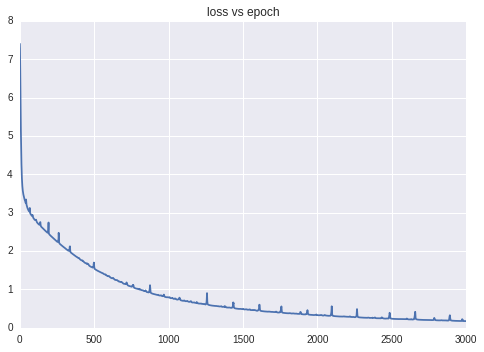

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot([i for i in xrange(len(LOSS))], LOSS)
plt.title('loss vs epoch')
plt.show()

As i expected for the loss slope, now let we test our model for 10 sentences from the input dataset

In [27]:
def label_to_text(label):
    string = ''
    for i in xrange(len(label)):
        if label[i] == 0 or label[i] == 1:
            continue
        string += vocab_predict[label[i]] + ' '
    return string

for i in xrange(10):
    rand = np.random.randint(len(split_inputs))
    in_testing = feeding(split_inputs[rand: rand + 1], split_predict[rand: rand + 1])
    predict = sess.run(decoder_prediction, in_testing)
    print 'input: ' + str(in_testing[encoder_inputs].T)
    print 'supposed label: ' + str(in_testing[decoder_targets].T)
    print 'predict label:' + str(predict.T)
    print 'predict text: ' + str(label_to_text(predict.T[0])) + '\n'

input: [[  6  80 940 941   0   0   0]]
supposed label: [[ 20   9 955  10 956   2 957   1]]
predict label:[[ 27   9 955  10 956   2 957   1]]
predict text: Kita kau terlahir di dunia yang damai, 

input: [[997 368   7 998   0   0]]
supposed label: [[1021   27  140   14 1022 1023    1]]
predict label:[[  27   27  140   14 1022 1023    1]]
predict text: Kita Kita mula dengan proses penyejukkan. 

input: [[   4   19  179 1007    2]]
supposed label: [[  13  233   48 1031   55    1]]
predict label:[[  13  492   48 1354    0    1]]
predict text: Kau bagus perkara pemindahan 

input: [[244  18]]
supposed label: [[ 102 1357    1]]
predict label:[[ 38   7 205]]
predict text: sekolah untuk sesungut. 

input: [[305 185  13]]
supposed label: [[ 67  22 725   1]]
predict label:[[  13 1189 1260    1]]
predict text: Kau sopan kesusahan. 

input: [[  51 1063  398]]
supposed label: [[  14  334 1091    1]]
predict label:[[  7 531 967   1]]
predict text: untuk jauh kawalan. 

input: [[ 401 1079 1080 1081  

Some of the outputs are nice, and our input not normalized into smaller number. its not easy for rnn to generate large integer number in the network.

But you got the concept right?